In [1]:
from pathlib import Path
from LHC_FillingPattern import LHCFillingPattern 
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import pandas as pd
from matplotlib.lines import Line2D
from scipy.integrate import cumtrapz 

In [2]:
DATADIR = Path("/eos/project/l/lhc-lumimod/LuminosityFollowUp/md_data/MD15363""/HX:FILLN=10739/")
df = pd.read_parquet(DATADIR)   
#print(df.columns.tolist())
#fbmodes = pd.read_parquet(DATADIR)

In [3]:
ATLAS_PV = "ATLAS:BUNCH_LUMI_INST" 
CMS_PV = 'CMS:BUNCH_LUMI_INST'
BETASTAR_PV    = "HX:BETASTAR_IP1" #'HX:BETASTAR_IP1', HX:BETASTAR_IP2', 'HX:BETASTAR_IP5', 'HX:BETASTAR_IP8'
XING_PV = 'LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value'

bids = [20, 500, 1250, 1800,2874]  

In [5]:
ATLAS_PV = "ATLAS:BUNCH_LUMI_INST"
CMS_PV   = "CMS:BUNCH_LUMI_INST"
BUNCH_GROUPS = {
    "q = 1"  : ([20, 500],    "green"),
    "q = 1.5": ([1250, 1800], "red"),
}
SOLO_BID = 2874  # plotted in black
dynamic_ylim = True  # Enable dynamic y-axis scaling
title_suffix = "Full window with dynamic y-limit"
def load_bunch_array(pv_name: str, bid_list):
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    mat    = np.stack(raw[pv_name].values)  # nTimes × 3564
    sliced = mat[:, bid_list]
    return pd.DataFrame(
        sliced,
        index   = raw.index,
        columns = [f"B{bid}" for bid in bid_list]
    )

all_bids = [*BUNCH_GROUPS["q = 1"][0], *BUNCH_GROUPS["q = 1.5"][0], SOLO_BID]
df_atlas = load_bunch_array(ATLAS_PV, all_bids)
df_cms = load_bunch_array(CMS_PV, all_bids)
#df_atlas.dropna().head(400)
#df_cms.dropna().head(5000)

In [6]:
# 1. Drop rows where *all* bunch columns are NaN
df_clean_atlas = df_atlas.dropna(how="all")
df_clean_cms   = df_cms.dropna(how="all")

# 2. Align to a common one-second grid by rounding timestamps to the nearest second
df_clean_atlas.index = df_clean_atlas.index.round("S")
df_clean_cms.index   = df_clean_cms.index.round("S")

# 3. Build the unified time index
t0 = min(df_clean_atlas.index.min(), df_clean_cms.index.min())
t1 = max(df_clean_atlas.index.max(), df_clean_cms.index.max())
time_grid = pd.date_range(t0, t1, freq="1S")

# 4. Reindex & interpolate to fill gaps
atlas_sync = (
    df_clean_atlas
    .reindex(time_grid)
    .interpolate(method="time")
    .ffill()
    .bfill()
)

cms_sync = (
    df_clean_cms
    .reindex(time_grid)
    .interpolate(method="time")
    .ffill()
    .bfill()
)

# 5. Quick sanity check
print("ATLAS NaNs remaining:", atlas_sync.isna().sum().sum())
print("CMS   NaNs remaining:", cms_sync.isna().sum().sum())

ATLAS NaNs remaining: 0
CMS   NaNs remaining: 0


/tmp/ipykernel_3537142/424531793.py:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_clean_atlas.index = df_clean_atlas.index.round("S")
/tmp/ipykernel_3537142/424531793.py:7: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_clean_cms.index   = df_clean_cms.index.round("S")
/tmp/ipykernel_3537142/424531793.py:12: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_grid = pd.date_range(t0, t1, freq="1S")


/tmp/ipykernel_3537142/1122377654.py:4: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  time_grid = pd.date_range(t0, t1, freq="1S")


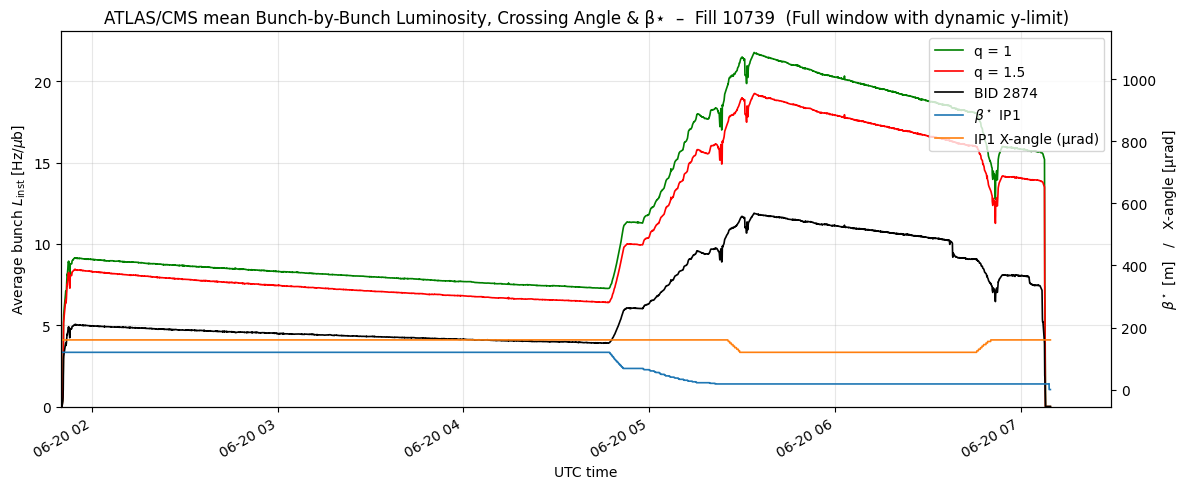

In [7]:
# ── 0) build your 1 s time grid from the already-synced atlas_sync & cms_sync
t0 = min(atlas_sync.index.min(), cms_sync.index.min())
t1 = max(atlas_sync.index.max(), cms_sync.index.max())
time_grid = pd.date_range(t0, t1, freq="1S")

def load_scalar_series(pv_name):
    """Return a Series resampled to 1 s bins (mean) with a clean datetime index."""
    raw = (
        dd.read_parquet(DATADIR, columns=[pv_name])
          .dropna()
          .compute()
    )
    raw.index = pd.to_datetime(raw.index, unit="ns")
    raw.sort_index(inplace=True)
    return (
        raw[pv_name]
        .astype(float)
        .resample("1S")
        .mean()
    )

BETASTAR_PV = "HX:BETASTAR_IP1"
XING_PV     = "LhcStateTracker:LHCBEAM:IP1-XING-H-MURAD:value"

# 1 s series for β⋆ and X-angle
beta_1s = load_scalar_series(BETASTAR_PV)
xing_1s = load_scalar_series(XING_PV)

# align to common grid
beta_sync = (beta_1s
             .reindex(time_grid)
             .interpolate(method="time")
             .ffill().bfill())
xing_sync = (xing_1s
             .reindex(time_grid)
             .interpolate(method="time")
             .ffill().bfill())

# ── 2) detector­-average luminosity, then group averages ────────────────────
avg_sync = (atlas_sync + cms_sync) / 2.0

group_defs = {
    "q = 1"           : BUNCH_GROUPS["q = 1"][0],
    "q = 1.5"         : BUNCH_GROUPS["q = 1.5"][0],
    f"BID {SOLO_BID}" : [SOLO_BID],
}
colours = {"q = 1": "green", "q = 1.5": "red", f"BID {SOLO_BID}": "black"}

# ── 3) assemble the plot ───────────────────────────────────────────────────
fig, ax_left = plt.subplots(figsize=(12, 5))

# left axis: luminosity groups
for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ax_left.plot(series.index, series.values,
                 label=label,
                 color=colours[label],
                 linewidth=1.2)

ax_left.set_xlabel("UTC time")
ax_left.set_ylabel(r"Average bunch $L_{\rm inst}$ [Hz/$\mu$b]")
ax_left.grid(alpha=0.3)

if dynamic_ylim:
    lo, hi = avg_sync.min().min(), avg_sync.max().max()
    ax_left.set_ylim(lo * 0.95, hi * 1.05)

# right axis: β⋆ and crossing angle
ax_right = ax_left.twinx()
ax_right.plot(beta_sync.index, beta_sync.values,
              label=r"$\beta^\star$ IP1",
              color="tab:blue",
              linewidth=1.2)
ax_right.plot(xing_sync.index, xing_sync.values,
              label=r"IP1 X-angle (µrad)",
              color="tab:orange",
              linewidth=1.2)
ax_right.set_ylabel(r"$\beta^\star$ [m]   /   X-angle [µrad]")
ax_right.tick_params(axis="y")

# combined legend
lines_l, labels_l = ax_left.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_left.legend(lines_l + lines_r, labels_l + labels_r, loc="upper right")

ax_left.set_title(
    f"ATLAS/CMS mean Bunch-by-Bunch Luminosity, Crossing Angle & β⋆  –  Fill 10739  ({title_suffix})"
)
fig.autofmt_xdate()
ax_left.set_xlim(left=pd.Timestamp("2025-06-20 01:50"))
plt.tight_layout()
plt.show()

In [8]:
# 1) Define the 4 h cutoff
start_time        = beta_sync.index[0]
four_hours_later  = start_time + pd.Timedelta(hours=4)

# 2) Restrict to times after the 4 h cutoff
beta_after_4h = beta_sync.loc[beta_sync.index > four_hours_later]

# 3) Compute the absolute step change and apply a small tolerance
tol        = 1e-6
beta_step  = beta_after_4h.diff().abs()
significant = beta_step > tol

# 4) Find the first timestamp where a “significant” change occurs
if significant.any():
    first_change_after_4h = significant.idxmax()  
    print("First β⋆ change after 4 h at:", first_change_after_4h)
else:
    print("No β⋆ change found after 4 h.")


First β⋆ change after 4 h at: 2025-06-20 04:47:13


First β* change after 4 h at: 2025-06-20 04:47:13


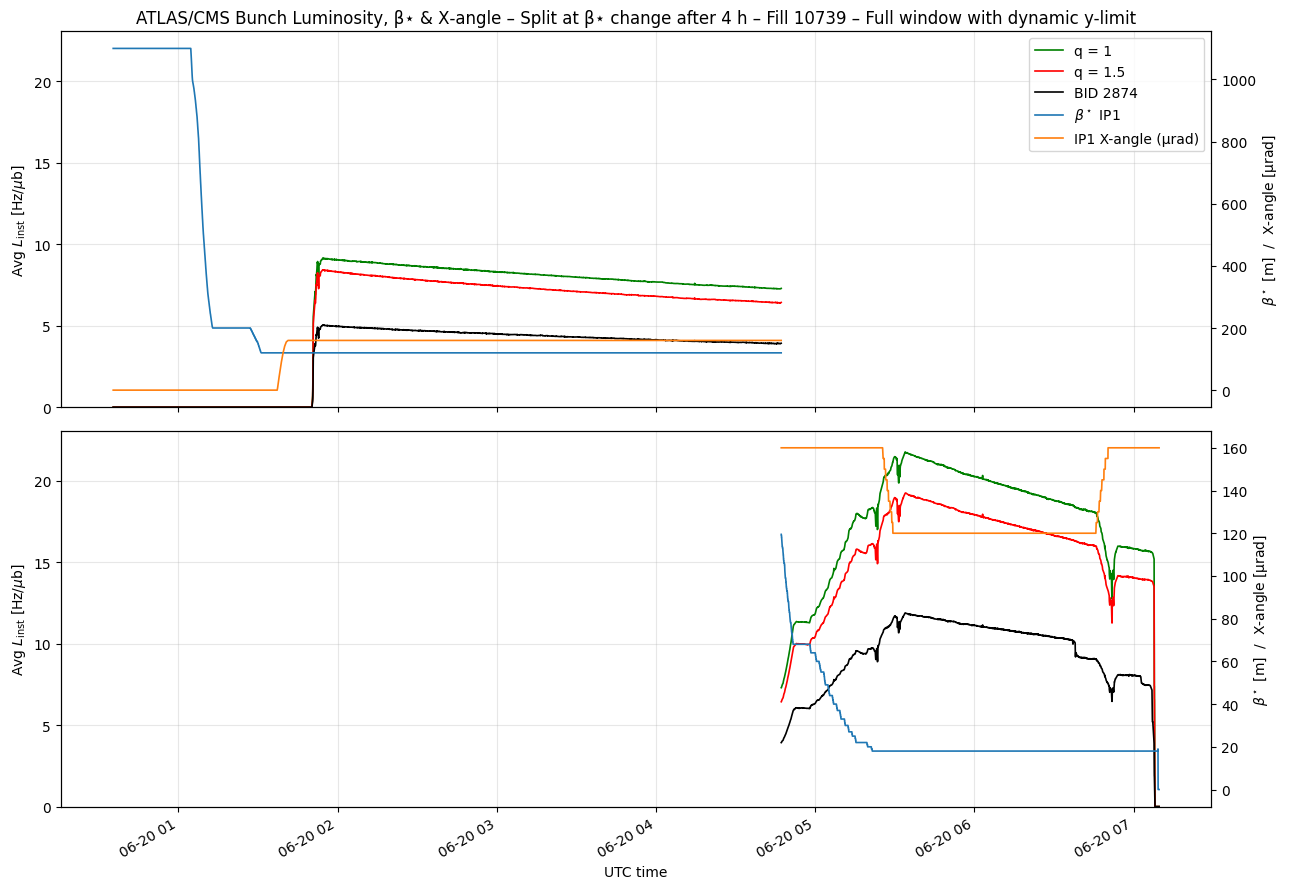

In [10]:
start_time       = beta_sync.index[0]
four_hours_later = start_time + pd.Timedelta(hours=4)

beta_diff = beta_sync.diff()
tol = 1e-6
post_4h_change = beta_diff[
    (beta_diff.abs() > tol) &
    (beta_diff.index > four_hours_later)
]
if post_4h_change.empty:
    raise ValueError("No β* change detected after 4 hours.")
change_time = post_4h_change.index[0]
print("First β* change after 4 h at:", change_time)
time_windows = [
    (beta_sync.index[0], change_time),    # before β⋆ change
    (change_time,       beta_sync.index[-1]),  # after β⋆ change
]

# Step 3: Prepare group definitions and colours
group_defs = {
    "q = 1":    BUNCH_GROUPS["q = 1"][0],
    "q = 1.5":  BUNCH_GROUPS["q = 1.5"][0],
    f"BID {SOLO_BID}": [SOLO_BID],
}
colours = {
    "q = 1":    "green",
    "q = 1.5":  "red",
    f"BID {SOLO_BID}": "black",
}

# Step 4: Plot both panels
fig, axes = plt.subplots(2, 1, figsize=(13, 9), sharex=True)

for i, (t_start, t_end) in enumerate(time_windows):
    ax_left = axes[i]
    # Plot luminosity group averages
    for label, bids in group_defs.items():
        series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
        seg = series[(series.index >= t_start) & (series.index < t_end)]
        ax_left.plot(seg.index, seg.values,
                     label=label,
                     color=colours[label],
                     linewidth=1.2)
    ax_left.set_ylabel(r"Avg $L_{\rm inst}$ [Hz/$\mu$b]")
    ax_left.grid(alpha=0.3)
    if dynamic_ylim:
        lo, hi = avg_sync.min().min(), avg_sync.max().max()
        ax_left.set_ylim(lo * 0.95, hi * 1.05)

    # Plot β⋆ and X-angle on right axis
    ax_right = ax_left.twinx()
    beta_seg = beta_sync[(beta_sync.index >= t_start) & (beta_sync.index < t_end)]
    xing_seg = xing_sync[(xing_sync.index >= t_start) & (xing_sync.index < t_end)]
    ax_right.plot(beta_seg.index, beta_seg.values,
                  label=r"$\beta^\star$ IP1",
                  color="tab:blue", linewidth=1.2)
    ax_right.plot(xing_seg.index, xing_seg.values,
                  label=r"IP1 X-angle (µrad)",
                  color="tab:orange", linewidth=1.2)
    ax_right.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")

    # Only show one combined legend (on first panel)
    if i == 0:
        lines_l, labels_l = ax_left.get_legend_handles_labels()
        lines_r, labels_r = ax_right.get_legend_handles_labels()
        ax_left.legend(lines_l + lines_r,
                       labels_l + labels_r,
                       loc="upper right")

# Final formatting
axes[0].set_title(
    f"ATLAS/CMS Bunch Luminosity, β⋆ & X‐angle – Split at β⋆ change after 4 h – "
    f"Fill 10739 – {title_suffix}"
)
axes[1].set_xlabel("UTC time")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

First β⋆ change after 4 h at: 2025-06-20 04:47:13
Normalization window starts at: 2025-06-20 01:54:31


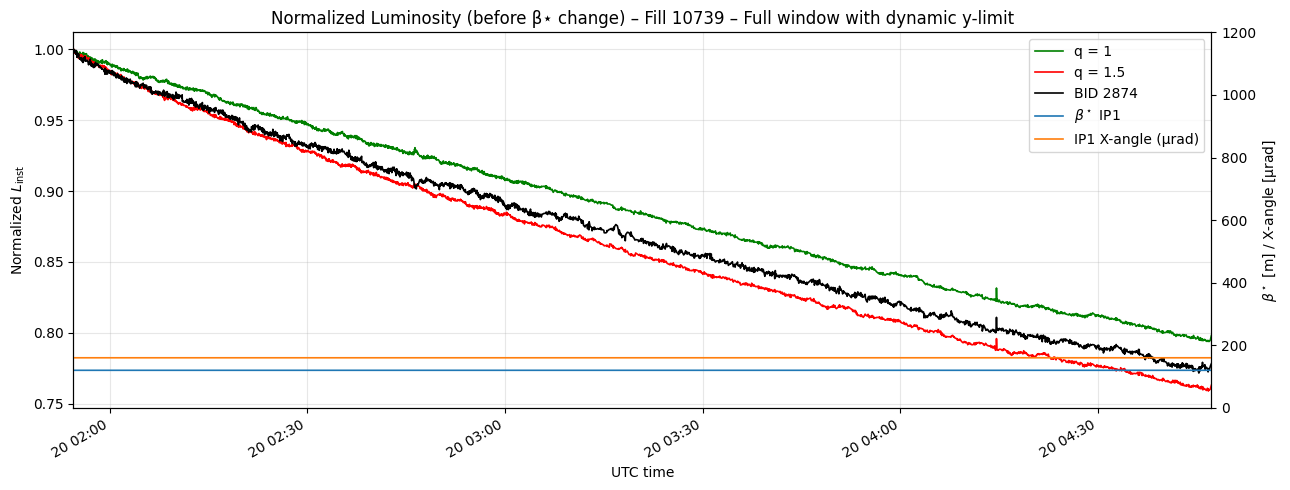

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# ── Assumes these are already defined:
# atlas_sync, cms_sync: synced 1 s DataFrames of luminosity
# beta_sync, xing_sync: synced 1 s Series of β⋆ and X-angle at IP1
# avg_sync            : (atlas_sync + cms_sync)/2
# group_defs, colours : your group definitions and color map
# SOLO_BID, title_suffix, dynamic_ylim

# Step 1: Detect β⋆ change after 4 h
start_time       = beta_sync.index[0]
four_hours_later = start_time + pd.Timedelta(hours=4)

beta_diff = beta_sync.diff()
tol = 1e-6
post4 = beta_diff[(beta_diff.abs() > tol) & (beta_diff.index > four_hours_later)]
if post4.empty:
    raise ValueError("No β⋆ change detected after 4 hours.")
change_time = post4.index[0]
print("First β⋆ change after 4 h at:", change_time)

# Step 2: Find normalization window start as earliest peak
max_times = []
for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    before = series.loc[start_time:change_time]
    normed = before / before.max()
    max_times.append(normed.idxmax())

norm_start_time = min(max_times)
print("Normalization window starts at:", norm_start_time)

# Step 3: Compute per-group peaks in [norm_start_time, change_time]
max_values = {}
for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    window = series.loc[norm_start_time:change_time]
    max_values[label] = window.max()

# Step 4: Plot normalized luminosity and β⋆/X-angle
fig, ax_lum = plt.subplots(figsize=(13, 5))

# Left axis: normalized luminosity
for label, bids in group_defs.items():
    series = avg_sync[[f"B{b}" for b in bids]].mean(axis=1).loc[norm_start_time:change_time]
    normed = series / max_values[label]
    ax_lum.plot(normed.index, normed.values,
                label=label, color=colours[label], linewidth=1.2)

ax_lum.set_ylabel(r"Normalized $L_{\rm inst}$")
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)
ax_lum.set_xlim(norm_start_time, change_time)

# Right axis: β⋆ and X-angle
ax_right = ax_lum.twinx()
beta_slice = beta_sync.loc[norm_start_time:change_time]
xing_slice = xing_sync.loc[norm_start_time:change_time]
ax_right.plot(beta_slice.index, beta_slice.values,
              label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax_right.plot(xing_slice.index, xing_slice.values,
              label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
ax_right.set_ylabel(r"$\beta^\star$ [m] / X-angle [µrad]")

# Combine legends
lines_l, labels_l = ax_lum.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_lum.legend(lines_l + lines_r, labels_l + labels_r, loc="upper right")

# Optional fixed y-limit on the right axis
ax_right.set_ylim(0, 1200)

# Title & formatting
ax_lum.set_title(
    f"Normalized Luminosity (before β⋆ change) – Fill 10739 – {title_suffix}"
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


β⋆ first changes after 4 h at: 2025-06-20 04:47:13
Normalization window starts at: 2025-06-20 01:54:31


/tmp/ipykernel_3537142/2597901837.py:31: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integral = cumtrapz(seg.values, t_sec, initial=0.0)


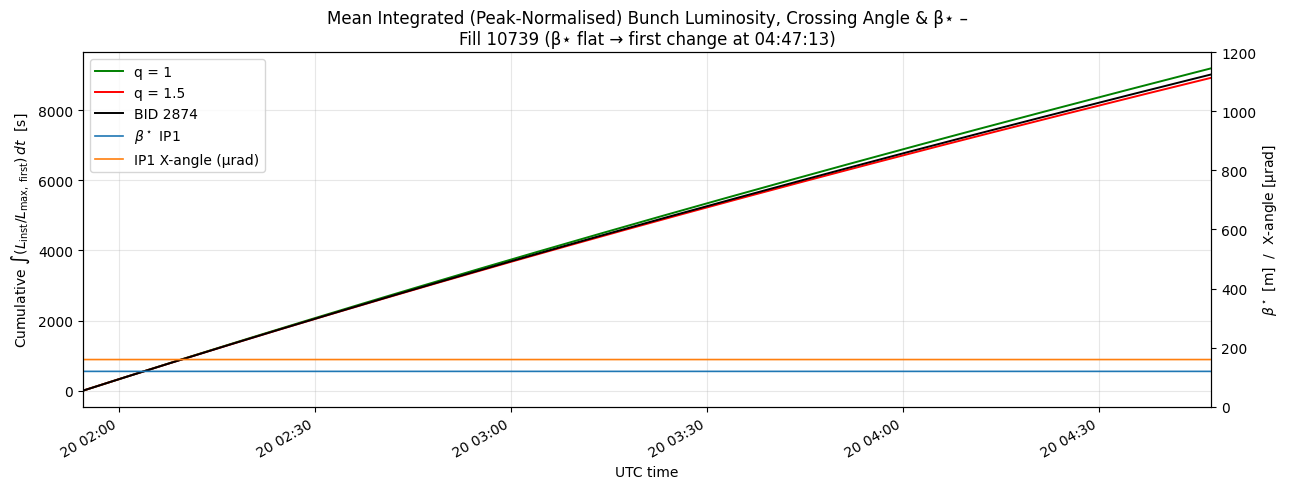

In [14]:
# Step 1: Find the first β⋆ change after 4 hours
t0       = beta_sync.index[0]
t4h      = t0 + pd.Timedelta(hours=4)
tol      = 1e-6
dβ       = beta_sync.diff()
post4    = dβ[(dβ.abs() > tol) & (dβ.index > t4h)]
if post4.empty:
    raise ValueError("No β⋆ change detected after 4 hours.")
t_change = post4.index[0]
print("β⋆ first changes after 4 h at:", t_change)

# Step 2: Find the earliest peak among your groups in [t0, t_change]
norm_candidates = []
norm_series_dict = {}
for label, bids in group_defs.items():
    s = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    w = s.loc[t0:t_change]
    norm = w / w.max()
    norm_series_dict[label] = norm
    norm_candidates.append(norm.idxmax())

norm_start = min(norm_candidates)
print("Normalization window starts at:", norm_start)

# Step 3: Plot cumulative integrated luminosity
fig, ax_lum = plt.subplots(figsize=(13, 5))

for label, norm in norm_series_dict.items():
    seg    = norm.loc[norm_start:t_change]
    t_sec  = (seg.index - seg.index[0]).total_seconds()
    integral = cumtrapz(seg.values, t_sec, initial=0.0)
    ax_lum.plot(seg.index, integral,
                label=label, color=colours[label], linewidth=1.4)

ax_lum.set_xlim(norm_start, t_change)
ax_lum.set_ylabel(r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]")
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)

# Step 4: Twin axis for β⋆ & X-angle
ax_right = ax_lum.twinx()
β_seg     = beta_sync.loc[norm_start:t_change]
xing_seg  = xing_sync.loc[norm_start:t_change]

ax_right.plot(β_seg.index, β_seg.values,
              label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2)
ax_right.plot(xing_seg.index, xing_seg.values,
              label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2)
ax_right.set_ylabel(r"$\beta^\star$ [m]  /  X-angle [µrad]")
ax_right.set_ylim(0, 1200)

# Combined legend
l_l, lab_l = ax_lum.get_legend_handles_labels()
l_r, lab_r = ax_right.get_legend_handles_labels()
ax_lum.legend(l_l + l_r, lab_l + lab_r, loc="upper left")

# Title & layout
ax_lum.set_title(
    "Mean Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ –\n"
    f"Fill 10739 (β⋆ flat → first change at {t_change.strftime('%H:%M:%S')})"
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [15]:
def sym_pct_diff(a, b):
    return 100 * abs(a - b) / ((a + b) / 2)

def rel_pct_diff(ref, val):
    return 100 * (val - ref) / ref

# Step A: Rebuild cumulative DataFrame using the normalized series
df_cum_norm = pd.DataFrame()

for label, normed in norm_series_dict.items():
    seg      = normed.loc[norm_start:t_change]  # use norm_start and t_change
    times_sec = (seg.index - seg.index[0]).total_seconds()
    integrated = cumtrapz(seg.values, times_sec, initial=0.0)
    df_cum_norm[label] = pd.Series(integrated, index=seg.index)

# Step B: Extract final cumulative values at the β⋆ change
final_values_norm = df_cum_norm.iloc[-1]

print("\nPeak-normalised cumulative luminosity delivered up to β⋆ change:\n")
print(final_values_norm.to_string(float_format="%.3e"))

print("\nAvailable group labels:", final_values_norm.index.tolist())

# Step C: Compare q = 1 vs. q = 1.5
label_q1   = "q = 1"
label_q15  = "q = 1.5"

if label_q1 not in final_values_norm or label_q15 not in final_values_norm:
    raise ValueError("Expected group labels not found in final results.")

val_q1  = final_values_norm[label_q1]
val_q15 = final_values_norm[label_q15]

sym_pct = sym_pct_diff(val_q1, val_q15)
rel_pct = rel_pct_diff(val_q1, val_q15)

print("\nPeak-normalised cumulative luminosity at β⋆ change (GROUP LEVEL):\n")
print(f"  q = 1   (avg B20 + B500):      {val_q1 : .3e} s")
print(f"  q = 1.5 (avg B1250 + B1800): {val_q15: .3e} s")
print(f"  Symmetric % difference:       {sym_pct:.3f} %")
print(f"  Relative  % difference (ref q=1): {rel_pct:.3f} %")


Peak-normalised cumulative luminosity delivered up to β⋆ change:

q = 1      9.196e+03
q = 1.5    8.925e+03
BID 2874   9.020e+03

Available group labels: ['q = 1', 'q = 1.5', 'BID 2874']

Peak-normalised cumulative luminosity at β⋆ change (GROUP LEVEL):

  q = 1   (avg B20 + B500):       9.196e+03 s
  q = 1.5 (avg B1250 + B1800):  8.925e+03 s
  Symmetric % difference:       2.984 %
  Relative  % difference (ref q=1): -2.940 %


/tmp/ipykernel_3537142/4029243063.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(seg.values, times_sec, initial=0.0)
/tmp/ipykernel_3537142/4029243063.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(seg.values, times_sec, initial=0.0)
/tmp/ipykernel_3537142/4029243063.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(seg.values, times_sec, initial=0.0)


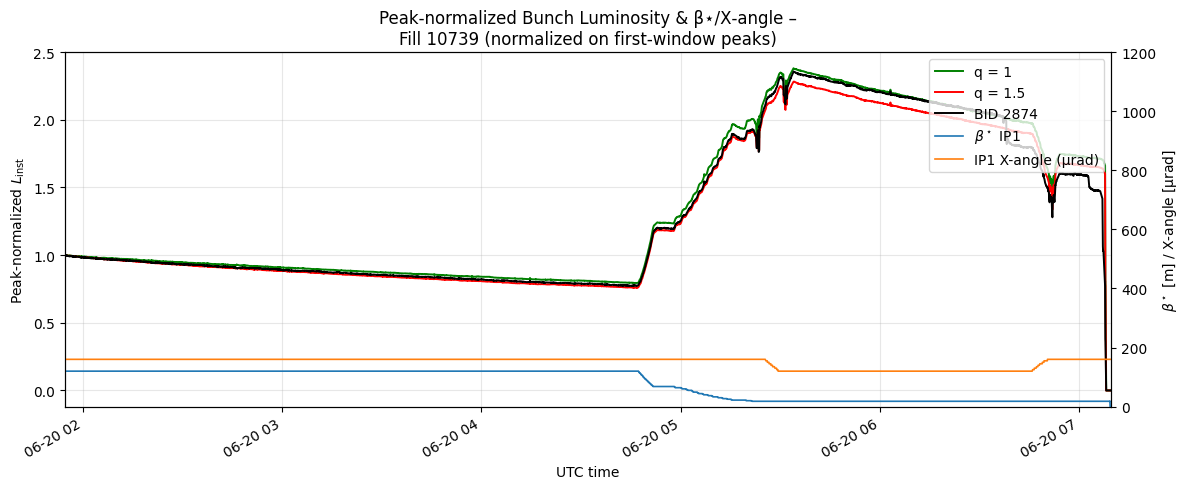

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# ── Prerequisites (already defined) ─────────────────────────────────────────
# avg_sync      : DataFrame of (atlas_sync + cms_sync)/2 at 1 s cadence
# beta_sync     : Series of β⋆ at the same timestamps
# xing_sync     : Series of crossing angle at the same timestamps
# group_defs    : {"q = 1": [20,500], "q = 1.5": [1250,1800], f"BID {SOLO_BID}":[SOLO_BID]}
# colours       : color map for those group labels
# title_suffix  : a string for the plot title

# Step 1: Detect when β⋆ first changes after 4 h
t0       = beta_sync.index[0]
t4h      = t0 + pd.Timedelta(hours=4)
tol      = 1e-6
dβ       = beta_sync.diff()
post4    = dβ[(dβ.abs() > tol) & (dβ.index > t4h)]
if post4.empty:
    raise ValueError("No β⋆ change detected after 4 hours.")
t_change = post4.index[0]

# Step 2: Find earliest peak of each group in [t0, t_change]
peak_times = []
for label, bids in group_defs.items():
    grp    = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    before = grp.loc[t0:t_change]
    peak_times.append((before / before.max()).idxmax())
norm_start = min(peak_times)

# Step 3: Compute per-group normalization factors using the same reference window
max_values = {}
for label, bids in group_defs.items():
    grp        = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ref_window = grp.loc[t0:t_change]
    max_values[label] = ref_window.max()

# Step 4: Plot peak-normalized luminosity curves over the full window
end_time = avg_sync.index[-1]
fig, ax_lum = plt.subplots(figsize=(12, 5))

for label, bids in group_defs.items():
    grp_full  = avg_sync[[f"B{b}" for b in bids]].mean(axis=1).loc[norm_start:end_time]
    normed    = grp_full / max_values[label]
    ax_lum.plot(
        normed.index, normed.values,
        label=label, color=colours[label], linewidth=1.4
    )

ax_lum.set_xlim(norm_start, end_time)
ax_lum.set_ylabel(r"Peak‐normalized $L_{\rm inst}$")
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)

# Step 5: Overlay β⋆ and crossing angle
ax_right = ax_lum.twinx()
β_full    = beta_sync.loc[norm_start:end_time]
xing_full = xing_sync.loc[norm_start:end_time]

ax_right.plot(
    β_full.index, β_full.values,
    label=r"$\beta^\star$ IP1", color="tab:blue", linewidth=1.2
)
ax_right.plot(
    xing_full.index, xing_full.values,
    label=r"IP1 X-angle (µrad)", color="tab:orange", linewidth=1.2
)
ax_right.set_ylabel(r"$\beta^\star$ [m] / X-angle [µrad]")
ax_right.set_ylim(0, 1200)

# Step 6: Combined legend and title
lines_l, labels_l = ax_lum.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_lum.legend(lines_l + lines_r, labels_l + labels_r, loc="upper right")

ax_lum.set_title(
    f"Peak‐normalized Bunch Luminosity & β⋆/X‐angle –\n"
    f"Fill 10739 (normalized on first‐window peaks)"
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()


/tmp/ipykernel_3537142/2694145004.py:25: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_int   = cumtrapz(normed.values, times_sec, initial=0.0)
/tmp/ipykernel_3537142/2694145004.py:25: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_int   = cumtrapz(normed.values, times_sec, initial=0.0)
/tmp/ipykernel_3537142/2694145004.py:25: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cum_int   = cumtrapz(normed.values, times_sec, initial=0.0)


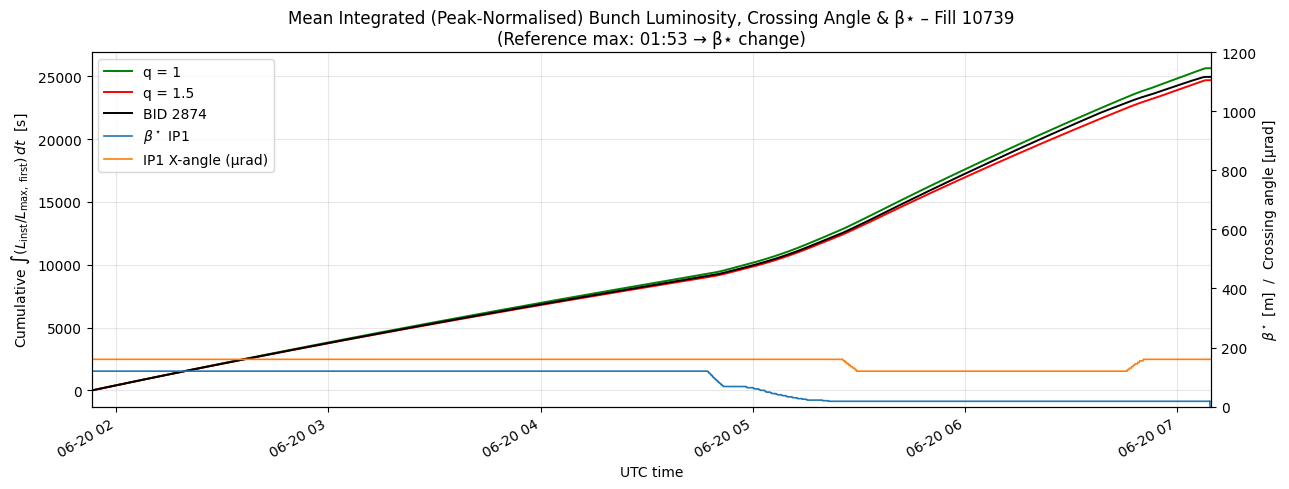

In [17]:
# 1) Compute the reference max for each bunch‐group in [01:53 → β⋆ change]
start_time = beta_sync.index[0].replace(hour=1, minute=53, second=0)

max_values = {}
for label, bids in group_defs.items():
    series_ref = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ref_slice  = series_ref.loc[start_time:t_change]
    max_values[label] = ref_slice.max()

# 2) Define the full integration window
norm_start_time = start_time
end_time        = avg_sync.index[-1]

# 3) Build and plot the cumulative integrals
fig, ax_lum = plt.subplots(figsize=(13, 5))

for label, bids in group_defs.items():
    # Fetch and normalize the full slice
    series_full = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    full_slice  = series_full.loc[norm_start_time:end_time]
    normed      = full_slice / max_values[label]

    # Compute elapsed seconds and integrate
    times_sec = (full_slice.index - full_slice.index[0]).total_seconds()
    cum_int   = cumtrapz(normed.values, times_sec, initial=0.0)

    ax_lum.plot(
        full_slice.index,
        cum_int,
        label=label,
        color=colours[label],
        linewidth=1.4
    )

# Style left axis
ax_lum.set_ylabel(
    r"Cumulative $\int (L_{\rm inst}/L_{\max,\;{\rm first}})\,dt$  [s]"
)
ax_lum.set_xlabel("UTC time")
ax_lum.grid(alpha=0.3)
ax_lum.set_xlim(norm_start_time, end_time)

# 4) Secondary axis: β⋆ & crossing angle
ax_right = ax_lum.twinx()
beta_full = beta_sync.loc[norm_start_time:end_time]
xing_full = xing_sync.loc[norm_start_time:end_time]

ax_right.plot(
    beta_full.index, beta_full.values,
    label=r"$\beta^\star$ IP1",
    color="tab:blue",
    linewidth=1.2
)
ax_right.plot(
    xing_full.index, xing_full.values,
    label=r"IP1 X-angle (µrad)",
    color="tab:orange",
    linewidth=1.2
)
ax_right.set_ylabel(r"$\beta^\star$ [m]  /  Crossing angle [µrad]")
ax_right.set_ylim(0, 1200)

# 5) Combine legends & finalize
lines_l, labels_l = ax_lum.get_legend_handles_labels()
lines_r, labels_r = ax_right.get_legend_handles_labels()
ax_lum.legend(
    lines_l + lines_r,
    labels_l + labels_r,
    loc="upper left"
)

ax_lum.set_title(
    "Mean Integrated (Peak-Normalised) Bunch Luminosity, Crossing Angle & β⋆ – Fill 10739\n"
    "(Reference max: 01:53 → β⋆ change)"
)
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

In [24]:
def sym_pct_diff(a, b):
    """Symmetric percent difference between a and b."""
    return 100 * abs(a - b) / ((a + b) / 2)

def rel_pct_diff(ref, val):
    """Relative percent difference of val vs. ref."""
    return 100 * (val - ref) / ref

# Assumed already defined in your session:
#   beta_sync      : pd.Series of β⋆ at 1 s cadence
#   avg_sync       : pd.DataFrame of mean ATLAS/CMS luminosity at 1 s cadence
#   group_defs     : dict mapping labels to lists of BID ints
#   t_change       : Timestamp when β⋆ first changed
#   norm_start_time: Timestamp from which to start integrating
#   end_time       : last timestamp in avg_sync

# 1) Compute reference-window maxima (start_time → t_change)
start_time = beta_sync.index[0].replace(hour=1, minute=53, second=0)
max_values = {}
for label, bids in group_defs.items():
    grp        = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    ref_window = grp.loc[start_time:t_change]
    max_values[label] = ref_window.max()

# 2) Build normalized time series for each group over the full window
norm_series_dict = {}
for label, bids in group_defs.items():
    grp_full   = avg_sync[[f"B{b}" for b in bids]].mean(axis=1)
    slice_full = grp_full.loc[norm_start_time:end_time]
    norm_series_dict[label] = slice_full / max_values[label]

# 3) Integrate each normalized series up to t_change
df_cum_norm = pd.DataFrame()
for label, normed in norm_series_dict.items():
    seg      = normed.loc[norm_start_time:t_change]
    times_sec = (seg.index - seg.index[0]).total_seconds()
    integrated = cumtrapz(seg.values, times_sec, initial=0.0)
    df_cum_norm[label] = pd.Series(integrated, index=seg.index)

# 4) Extract final cumulative values at the β⋆ change
final_values_norm = df_cum_norm.loc[:t_change].iloc[-1]

print("\nPeak-normalised cumulative luminosity delivered up to β⋆ change:\n")
print(final_values_norm.to_string(float_format="%.3e"))

# 5) Compute and display group-level comparisons
label_q1  = "q = 1"
label_q15 = "q = 1.5"
for lbl in (label_q1, label_q15):
    if lbl not in final_values_norm:
        raise ValueError(f"Expected group label '{lbl}' not found in results.")

val_q1  = final_values_norm[label_q1]
val_q15 = final_values_norm[label_q15]

sym_pct = sym_pct_diff(val_q1, val_q15)
rel_pct = rel_pct_diff(val_q1, val_q15)

print("\nGroup-level results at β⋆ change:")
print(f"  {label_q1:12s}: {val_q1 : .3e} s")
print(f"  {label_q15:12s}: {val_q15: .3e} s")
print(f"  Symmetric % difference:      {sym_pct:.3f} %")
print(f"  Relative   % difference (ref {label_q1}): {rel_pct:.3f} %")











Peak-normalised cumulative luminosity delivered up to β⋆ change:

q = 1      9.285e+03
q = 1.5    9.014e+03
BID 2874   9.109e+03

Group-level results at β⋆ change:
  q = 1       :  9.285e+03 s
  q = 1.5     :  9.014e+03 s
  Symmetric % difference:      2.956 %
  Relative   % difference (ref q = 1): -2.913 %


/tmp/ipykernel_3537142/3666732296.py:37: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(seg.values, times_sec, initial=0.0)
/tmp/ipykernel_3537142/3666732296.py:37: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(seg.values, times_sec, initial=0.0)
/tmp/ipykernel_3537142/3666732296.py:37: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  integrated = cumtrapz(seg.values, times_sec, initial=0.0)
